In [15]:
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime as dt
import requests
import zipfile
import geodatasets
from astral import LocationInfo 
from astral.sun import sun
from astral.location import Location
from bs4 import BeautifulSoup
from scipy import stats


### user input

In [30]:
year = 2024
month = 10
wojewodztwo = "mazowieckie"
powiat = "warszawski zachodni"

city = LocationInfo("Warsaw", "Poland", "Europe/Warsaw", 52.22977, 21.01178)
warsaw = Location(city)

#### station data
Effacility data attributes: 
- ifcid - kod stacji

<Axes: >

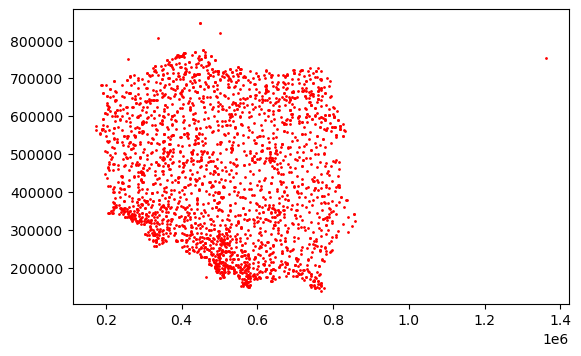

In [17]:
effacility_path = r"dane_meteorologiczne\effacility.geojson"
effacility = gpd.read_file(effacility_path)

# print(effacility.head())

effacility = effacility.to_crs(epsg=2180)
effacility.plot(markersize=1, color="red")

### administrative data
reads shapefiles of powiaty and województwa

<Axes: >

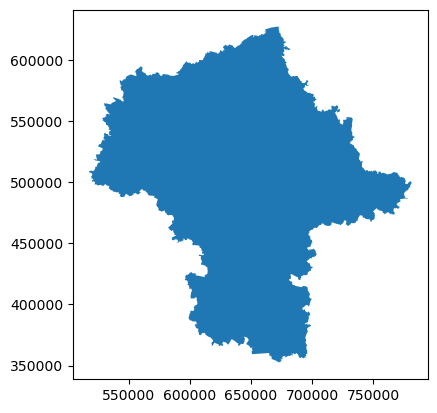

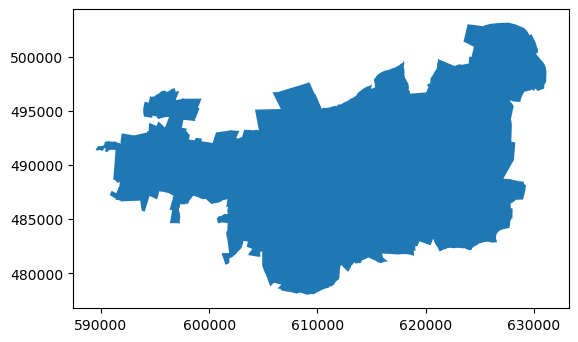

In [ ]:
woj_path = r"dane_administracyjne\woj.shp"
powiaty_path = r"dane_administracyjne\powiaty.shp"

woj_data = gpd.read_file(woj_path)
woj = woj_data.to_crs(epsg=2180)
# woj.plot()

powiaty_data = gpd.read_file(powiaty_path)
powiaty = powiaty_data.to_crs(epsg=2180)
# powiaty.plot()

wojewodztwo_gpd = woj_data[woj_data["name"] == wojewodztwo]
wojewodztwo_gpd.plot()
powiat_gpd = powiaty_data[powiaty_data["name"] == powiat]
powiat_gpd.plot()





### astronomical data
produce sunrise and sunset times for an example date

In [ ]:
# Get night and day data
day = 1

date = dt.datetime(year, month, day)
sun_data = sun(city.observer, date=date.date(), tzinfo=city.timezone)
sunrise = sun_data['sunrise']
sunset = sun_data['sunset']

# round times to nearest 10 minutes
sunrise_rounded = sunrise.replace(minute=10*round(sunrise.minute/10))
sunset_rounded = sunset.replace(minute=10*round(sunset.minute/10))
sunset_rounded = sunset_rounded.replace(second=0, microsecond=0)
sunrise_rounded = sunrise_rounded.replace(second=0, microsecond=0)

# change to GMT time
sunrise_rounded = sunrise_rounded.astimezone(dt.timezone.utc)
sunset_rounded = sunset_rounded.astimezone(dt.timezone.utc)

print("Sunrise: ", sunrise, "Sunrise GMT: ", sunrise_rounded)
print("Sunset: ", sunset, "Sunset GMT: ", sunset_rounded)

Sunrise:  2024-10-01 06:37:49.902973+02:00 Sunrise GMT:  2024-10-01 04:40:00+00:00
Sunset:  2024-10-01 18:12:10.426869+02:00 Sunset GMT:  2024-10-01 16:10:00+00:00


#### read files to a dataframe

Meteo data structure:
- 0 - kodSH stacji - station_code
- 1 - parametrSH - parameter_code
- 2 - data i godzina pomiaru - date
- 3 - wartość pomiaru - value


In [24]:
# Meteo files paths
air_temp_path = "dane_meteorologiczne/Meteo/B00300S_" + str(year) + "_" + str(month).zfill(2) + ".csv"
ground_temp_path = "dane_meteorologiczne/Meteo/B00305A_" + str(year) + "_" + str(month).zfill(2) + ".csv"
wind_direction_path = "dane_meteorologiczne/Meteo/B00202A_" + str(year) + "_" + str(month).zfill(2) + ".csv"
average_wind_speed_path = "dane_meteorologiczne/Meteo/B00702A_" + str(year) + "_" + str(month).zfill(2) + ".csv"
max_wind_speed_path = "dane_meteorologiczne/Meteo/B00703A_" + str(year) + "_" + str(month).zfill(2) + ".csv"
rainfall_10min_path = "dane_meteorologiczne/Meteo/B00608S_" + str(year) + "_" + str(month).zfill(2) + ".csv"
# rainfall_24h_path = "dane_meteorologiczne/Meteo/B00604S_" + str(year) + "_" + str(month).zfill(2) + ".csv"
# rainfall_1h_path = "dane_meteorologiczne/Meteo/B00606S_" + str(year) + "_" + str(month).zfill(2) + ".csv"
humidity_path = "dane_meteorologiczne/Meteo/B00802A_" + str(year) + "_" + str(month).zfill(2) + ".csv"
wind_gust_path = "dane_meteorologiczne/Meteo/B00714A_" + str(year) + "_" + str(month).zfill(2) + ".csv"
snow_water_reserve_path = "dane_meteorologiczne/Meteo/B00910A_" + str(year) + "_" + str(month).zfill(2) + ".csv"

all_paths = [air_temp_path, ground_temp_path, wind_direction_path, average_wind_speed_path, max_wind_speed_path, rainfall_10min_path, humidity_path, wind_gust_path, snow_water_reserve_path]
variables_names = ["air_temp", "ground_temp", "wind_direction", "average_wind_speed", "max_wind_speed", "rainfall_10min", "humidity", "wind_gust", "snow_water_reservoir"]

dataframes = {}

for path in all_paths:
    # check if file exists
    try:
        data = pd.read_csv(path, delimiter=";", header=None, names=["station_code", "parameter_code", "date", "value"])
        dataframes[variables_names[all_paths.index(path)]] = data

        # change date to datetime format and set its as GMT timezone
        dataframes[variables_names[all_paths.index(path)]].date = pd.to_datetime(dataframes[variables_names[all_paths.index(path)]].date)
        dataframes[variables_names[all_paths.index(path)]].date = dataframes[variables_names[all_paths.index(path)]].date.dt.tz_localize("GMT")
                
    except FileNotFoundError:
        dataframes[variables_names[all_paths.index(path)]] = None
        print(f"Data not found: {path}, skipping...")

air_temp, ground_temp, wind_direction, average_wind_speed, max_wind_speed, rainfall_10min, humidity, wind_gust, snow_water_reserve = dataframes.values()
print(dataframes["air_temp"])

Data not found: dane_meteorologiczne/Meteo/B00910A_2024_10.csv, skipping...
         station_code parameter_code                      date  value
0           249190090        B00300S 2024-10-01 00:00:00+00:00   3.29
1           249190090        B00300S 2024-10-01 00:10:00+00:00   3.16
2           249190090        B00300S 2024-10-01 00:20:00+00:00   3.05
3           249190090        B00300S 2024-10-01 00:30:00+00:00   3.01
4           249190090        B00300S 2024-10-01 00:40:00+00:00   3.07
...               ...            ...                       ...    ...
1185302     254150060        B00300S 2024-10-31 23:10:00+00:00  12.80
1185303     254150060        B00300S 2024-10-31 23:20:00+00:00  12.70
1185304     254150060        B00300S 2024-10-31 23:30:00+00:00  12.80
1185305     254150060        B00300S 2024-10-31 23:40:00+00:00  12.80
1185306     254150060        B00300S 2024-10-31 23:50:00+00:00  12.80

[1185307 rows x 4 columns]


#### count means of values

In [ ]:
# chooose variable based on user input
dataframe = air_temp

station_data = {
    "station_code": [],
    "date": [],
    "sunrise": [],
    "sunset": [],
    "mean_value_day": [],
    "mean_value_night": [],
    "median_value_day": [],
    "median_value_night": [],
    "trimmed_mean_value_day": [],
    "trimmed_mean_value_night": [],
}

days_in_month = dt.datetime(year, month+1, 1) - dt.datetime(year, month, 1)

for day in range(1, days_in_month.days+1):
    if dataframe is None:
        continue

    # Define that start and end of the day
    station_data["date"].append(dt.datetime(year, month, day))
    station_data["station_code"].append(station)

    start = dt.datetime(year, month, day, 0, 0, 0)
    end = dt.datetime(year, month, day, 23, 59, 59)
    start = start.astimezone(dt.timezone.utc)
    end = end.astimezone(dt.timezone.utc)

    # Get sunrise and sunset times
    date = dt.datetime(year, month, day)
    sun_data = sun(city.observer, date=date.date(), tzinfo=city.timezone)
    sunrise = sun_data['sunrise']
    sunset = sun_data['sunset']

    # round times to nearest 10 minutes
    sunrise_rounded = sunrise.replace(minute=(10*round(sunrise.minute/10)) % 60)
    sunset_rounded = sunset.replace(minute=(10*round(sunset.minute/10)) % 60)
    sunset_rounded = sunset_rounded.replace(second=0, microsecond=0)
    sunrise_rounded = sunrise_rounded.replace(second=0, microsecond=0)

    # change to GMT time
    sunrise_rounded = sunrise_rounded.astimezone(dt.timezone.utc)
    sunset_rounded = sunset_rounded.astimezone(dt.timezone.utc)

    station_data["sunrise"].append(sunrise)
    station_data["sunset"].append(sunset)


    unique_stations = dataframe["station_code"].unique()
    station = unique_stations[0]
    this_station_data = dataframe[dataframe["station_code"] == station]

    this_station_data["date"] = pd.to_datetime(this_station_data["date"])

    day_data = this_station_data[(this_station_data["date"] >= sunrise_rounded) & (this_station_data["date"] <= sunset_rounded)]
    night_data = this_station_data[(this_station_data["date"] >= start) & (this_station_data["date"] <= end)]
    night_data = night_data[(night_data["date"] < sunrise_rounded) | (night_data["date"] > sunset_rounded)]

    mean_value_day = day_data["value"].mean()
    median_value_day = day_data["value"].median()
    trimmed_mean_value_day = stats.trim_mean(day_data["value"], 0.1)

    mean_value_night = night_data["value"].mean() 
    median_value_night = night_data["value"].median()
    trimmed_mean_value_night = stats.trim_mean(night_data["value"], 0.1)
    
    station_data["mean_value_day"].append(mean_value_day)
    station_data["mean_value_night"].append(mean_value_night)
    station_data["median_value_day"].append(median_value_day)
    station_data["median_value_night"].append(median_value_night)
    station_data["trimmed_mean_value_day"].append(trimmed_mean_value_day)
    station_data["trimmed_mean_value_night"].append(trimmed_mean_value_night)

# Ensure all lists in station_values have the same length
max_length = max(len(lst) for lst in station_data.values())
for key in station_data:
    while len(station_data[key]) < max_length:
        station_data[key].append(None)

station_data = pd.DataFrame(station_data)
station_data.to_csv("station_data.csv", index=False)

C:\Users\mplaciszewska\AppData\Local\Temp\ipykernel_22016\1184314457.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_station_data["date"] = pd.to_datetime(this_station_data["date"])
C:\Users\mplaciszewska\AppData\Local\Temp\ipykernel_22016\1184314457.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_station_data["date"] = pd.to_datetime(this_station_data["date"])
C:\Users\mplaciszewska\AppData\Local\Temp\ipykernel_22016\1184314457.py:59: SettingWithCopyWarning: 
A value is trying to be set